# Methods - Demonstration
This notebook is used to showcase how the methods used in our project work on real examples. For our project, which is divided into 3 parts, we use the following methods / algorithms. 

### Part 1
- **Sentiment Analysis**: We run a sentiment analysis model to determine if the reviews of the movies are positive or negative. The model we decided to use is distilbert. This allows us to quantify the movie critics which will be useful in the creation of our success metric.
- **Success Metric Creation**: We create a "Success" metric that is based on the combination of different measures of movies success, such as: Box office revenue, ratings, reviews and popularity.

### Part 3
- **Time Series Prediction**: We predict future trends on some pandas timeseries created using the success metric. The generated series are closer to impact series as we apply a given change to the derivative of this impact series. The magnitude of the change in the derivative being proportional to the success metric. Using these impact series, we can make some predictions as to what the next dominant genres of the movie industry are going to be. 

In [2]:
# Imports needed to run the code
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

from src.models.PolynomialRegression import polynomial_regression
from src.models.ARIMA import arima
from src.utils.print_prediction import plot_results

### Sentiment analysis

In [4]:
# Loading a Pre-Trained Model from HuggingFace Hub
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

# Creating a Function to Run the Application
def run_classification(text):
    result = classifier(text)
    return result

# Running the Application
input_text = "I love ADA!"
pos_result = run_classification(input_text)
print(f"Input: {input_text}")
print(f"Classification: {pos_result}")

Input: I love ADA!
Classification: [{'label': 'POSITIVE', 'score': 0.9998760223388672}]


Thus the score is quite positive, as the label is 2 ! Yay, that's exactly what we expected 

In [5]:
input_text = "I hate handing in my assignments on the last day!"
neg_result = run_classification(input_text)
print(f"Input: {input_text}")
print(f"Classification: {neg_result}")

Input: I hate handing in my assignments on the last day!
Classification: [{'label': 'NEGATIVE', 'score': 0.9981616139411926}]


Here, as the lab is 0 it's a negative assessment...

In [ ]:
input_text = "The movie had a mix of strengths and weaknesses. Some aspects, like the cinematography, were well done, while others, such as the pacing, could have been improved"
neut_result = run_classification(input_text)
print(f"Input: {input_text}")
print(f"Classification: {neut_result}")

Once again on the mark !
We will thus implement this for our reviews.

### Success metric creation

### Time series prediction

The first step to predict the future trends in timeseries is to actually create these timeseries using our success metric. Here is the set of rules that we would like our "genre impact" timeseries to follow:
- Successful movies will have a greater impact then less successful movies on their respective genres
- The impact of successful movies on a genre will last longer

With this in mind, we decided to apply our success metric to the derivative of our impact timeseries. Here is an example of how this would work.

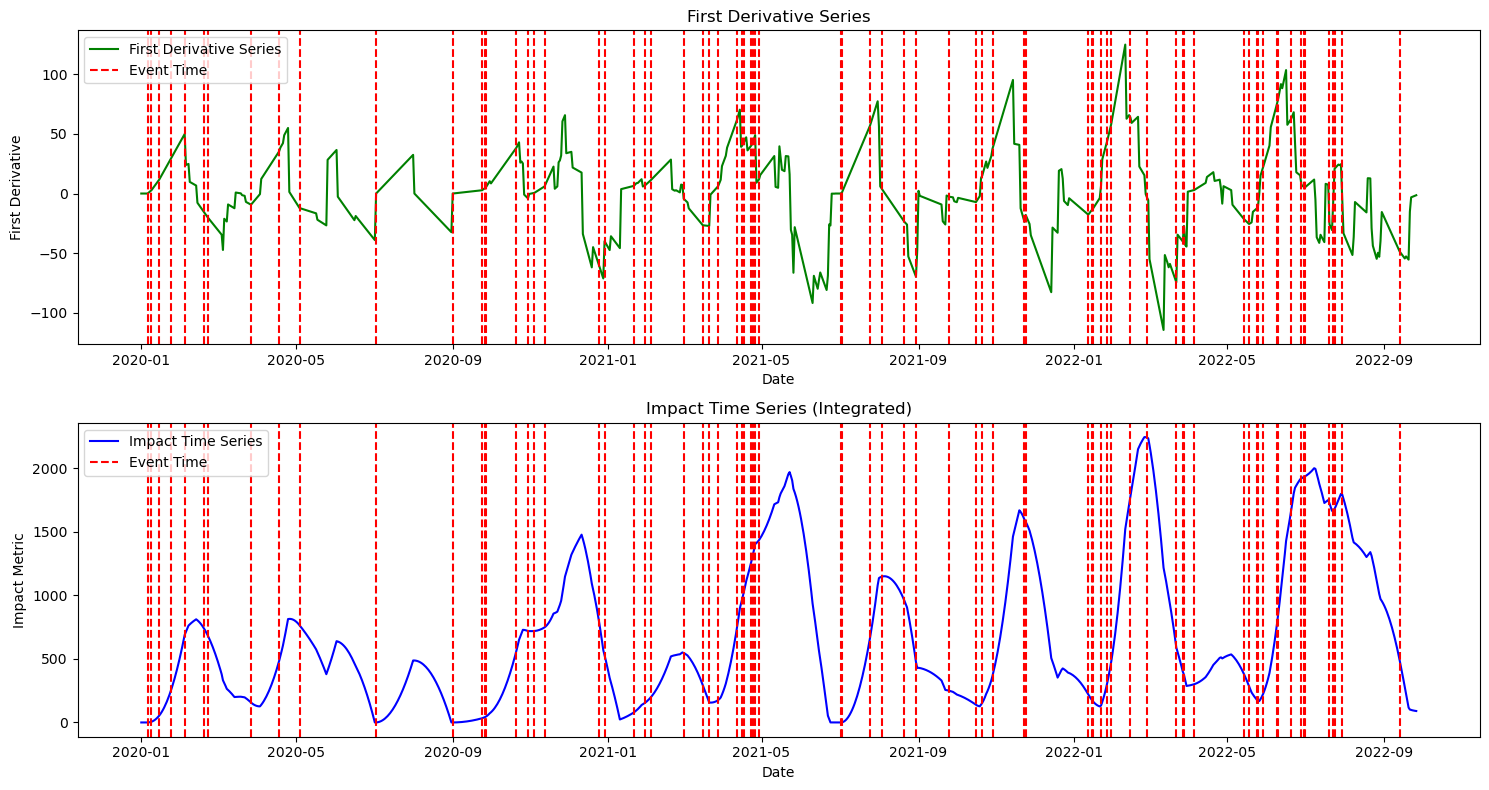

In [ ]:
# Need to adjust these values to have a better result. The best would probably be to have adaptable decay rates based on the impact of a movie
num_events = 75
linear_duration = 30  # Take 1 month for now. Might make sense to take 2 weeks also. Time during which the movies gains the interest of the public

time_index = pd.date_range(start='2020-01-01', periods=1000, freq='D')

first_derivative_series = pd.Series(0.0, index=time_index)

event_times = np.random.choice(range(len(first_derivative_series)), size=num_events, replace=False)
event_times.sort() 

for event_time in event_times:
    spike_value = np.random.exponential(20) 

    # We first add a linear growth (positive) 
    linear_end = min(event_time + linear_duration, len(first_derivative_series))
    linear_range = np.linspace(0, spike_value, linear_end - event_time)
    first_derivative_series.iloc[event_time:linear_end] += linear_range

    # Decay, the movie starts to lose the interest of the public (Want to do exponential later)
    decay_end = min(event_time + 2*linear_duration, len(first_derivative_series))
    decay_range = -np.linspace(0, spike_value, decay_end - linear_end)
    first_derivative_series.iloc[linear_end:decay_end] += decay_range

 
impact_series = first_derivative_series.cumsum()

plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(first_derivative_series, label="First Derivative Series", color="green")
for event_time in event_times:
    plt.axvline(time_index[event_time], color='red', linestyle='--', label="Event Time" if 'Event Time' not in plt.gca().get_legend_handles_labels()[1] else None)
plt.title("First Derivative Series")
plt.xlabel("Date")
plt.ylabel("First Derivative")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(impact_series, label="Impact Time Series", color="blue")
for event_time in event_times:
    plt.axvline(time_index[event_time], color='red', linestyle='--', label="Event Time" if 'Event Time' not in plt.gca().get_legend_handles_labels()[1] else None)
plt.title("Impact Time Series (Integrated)")
plt.xlabel("Date")
plt.ylabel("Impact Metric")
plt.legend()

plt.tight_layout()
plt.show()

As we can see from this simple example, there are a couple of factors which could play into a given genre's impact:
- A large number of medium success movies will have a large impact. 
- Few very successful movies will have a large impact. 
- Unsuccessful movies will have basically no impact on a given genre, even if there are a lot.

We are going to compare the performance of two different models. The first is a "simple" polynomial regression and the second is ARIMA or Autoregressive integrated moving average. ARIMA is a model which is often used in economics to make predictions of the market. 

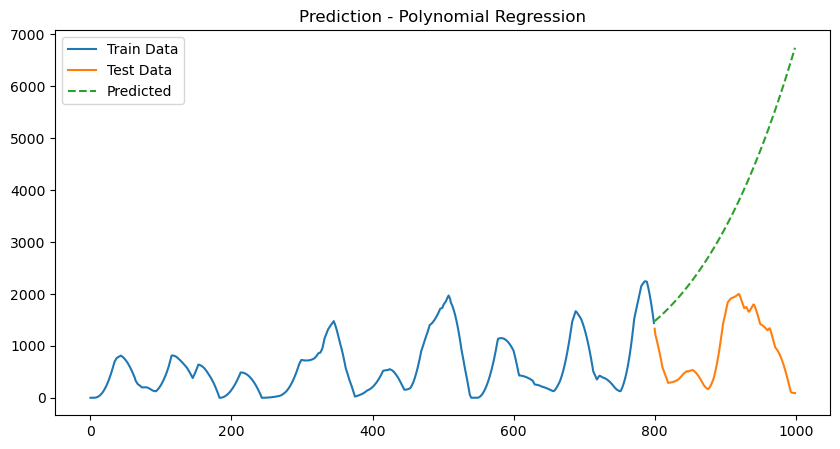

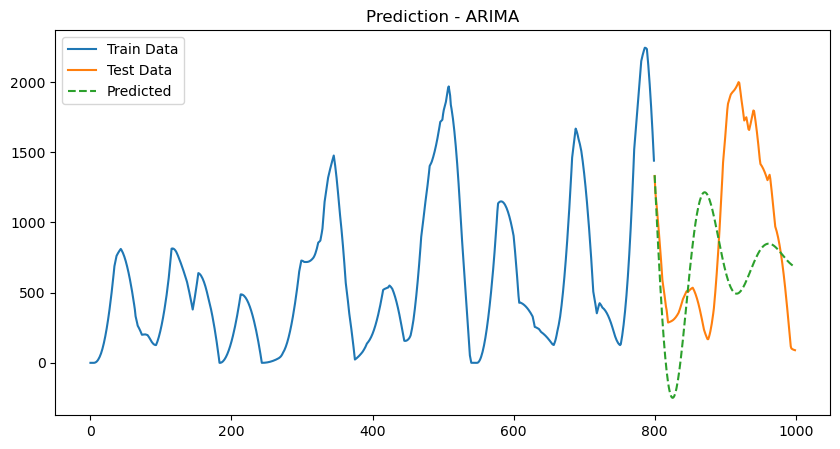

In [ ]:
np.random.seed(0)
n = 1000
time_series = pd.Series(0.5 * np.arange(n) + np.sin(np.linspace(0, 20, n)) + np.random.normal(scale=2, size=n))
train, test = impact_series[:800], impact_series[800:]

poly_predictions = polynomial_regression(train, degree=4, n_forecast=len(test + 1000))
plot_results(train, test, poly_predictions, "Prediction - Polynomial Regression")

# p is the number of previous points used to make the prediction
# d is the differentiating order to eliminate trends
# q is the moving average window
order = (400, 2, 20)  # (p,d,q)

arima_predictions = arima(train, order=(2, 1, 2), n_forecast=len(test+ 1000))
plot_results(train, test, arima_predictions, "Prediction - ARIMA")

One important thing to note is that the ARIMA model seem to be performing worse when the number of samples in the timeseries is smaller (See below). This could be an issue for genres that have started releasing movies recently. However, we might be able to fix this issue with better initial choices of parameters for the model. 

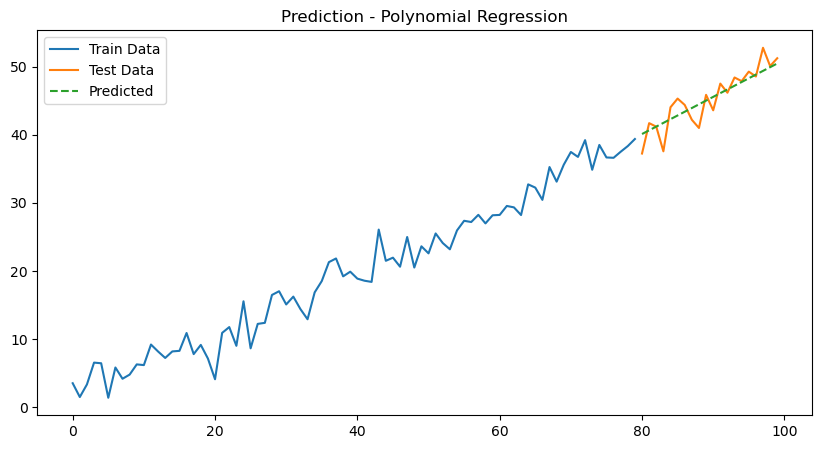

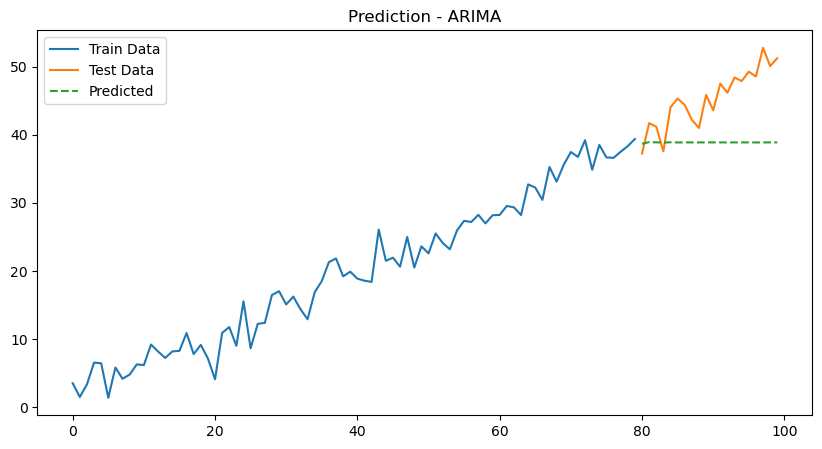

In [ ]:
np.random.seed(0)
n = 100
time_series = pd.Series(0.5 * np.arange(n) + np.sin(np.linspace(0, 20, n)) + np.random.normal(scale=2, size=n))
train, test = time_series[:80], time_series[80:]

poly_predictions = polynomial_regression(train, degree=3, n_forecast=len(test))
plot_results(train, test, poly_predictions, "Prediction - Polynomial Regression")

order = (20, 1, 20) 

arima_predictions = arima(train, order=(2, 1, 2), n_forecast=len(test))
plot_results(train, test, arima_predictions, "Prediction - ARIMA")